In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys
#sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
#sys.path.insert(0, '/opt/conda/envs/FairMOT/lib/python3.8/site-packages')
#sys.path.insert(0, '/usr/users/vogg/FairMOT/DCNv2')
#sys.path

import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from adjustText import adjust_text
import torch.nn.functional as F

import _init_paths
from opts import opts
from models.model import create_model, load_model
from models.decode import mot_decode, _nms, _topk
from tracking_utils.utils import *
from tracking_utils.log import logger
from tracking_utils.kalman_filter import KalmanFilter
from models import *
from tracker import matching
from tracker.basetrack import BaseTrack, TrackState
from tracker.multitracker import STrack
from utils.post_process import ctdet_post_process
from utils.image import get_affine_transform
from models.utils import _tranpose_and_gather_feat
from datasets.jde import letterbox

AttributeError: module 'typing' has no attribute '_ClassVar'

### Useful functions

In [4]:
def post_process(dets, meta):
    dets = dets.detach().cpu().numpy()
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = ctdet_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], 1)
    for j in range(1, 1 + 1):
        dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
    return dets[0]

def merge_outputs(detections):
    results = {}
    for j in range(1, 2):
        results[j] = np.concatenate(
            [detection[j] for detection in detections], axis=0).astype(np.float32)

    scores = np.hstack(
        [results[j][:, 4] for j in range(1, 2)])
    if len(scores) > 50:
        kth = len(scores) - 50
        thresh = np.partition(scores, kth)[kth]
        for j in range(1, 2):
            keep_inds = (results[j][:, 4] >= thresh)
            results[j] = results[j][keep_inds]
    return results

def get_info(frame_num, heatmap_thres = 0.1, model_i = None):
    '''
    Selects a frame (given by frame_num) from the current video (cap).
    Returns the image, top detections from the heatmap and corresponding id_feature maps.
    
    '''
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, img0 = cap.read()
    
    
    # Scale and fill grey borders
    img_box, _, _, _ = letterbox(img0, height=608, width=1088)

    # Normalize RGB
    img = img_box[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img, dtype=np.float32)
    img /= 255.0

    im_blob = torch.from_numpy(img).cuda().unsqueeze(0)

    width = img0.shape[1]
    height = img0.shape[0]
    inp_height = im_blob.shape[2]
    inp_width = im_blob.shape[3]
    c = np.array([width / 2., height / 2.], dtype=np.float32)
    s = max(float(inp_width) / float(inp_height) * height, width) * 1.0
    meta = {'c': c, 's': s,
            'out_height': inp_height // 4,
            'out_width': inp_width // 4}
    
    with torch.no_grad():
        output = model_i(im_blob)[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        reg = output['reg']

    dets, inds = mot_decode(hm, wh, reg=reg, ltrb=True, K=50)
    
    #find features to the IDs which were detected
    id_feature = _tranpose_and_gather_feat(id_feature, inds)
    id_feature = id_feature.squeeze(0)
    id_feature = id_feature.cpu().numpy()
    
    dets = post_process(dets, meta)
    dets = merge_outputs([dets])[1]

    # remove detections below the threshold

    remain_inds = dets[:, 4] > heatmap_thres
    dets = dets[remain_inds]
    inds = inds[:,remain_inds].cpu().numpy().squeeze()
    id_feature = id_feature[remain_inds]

    return img_box, hm, dets, inds, id_feature


def plot_frame(img, hm = None, pred_hm = None, kalman = None, top_preds = False, thres = 0.01, text = False):
    '''
    Visualizes an image.
    If hm is a heatmap, then it visualizes the heatmap on top of the image with alpha = 0.5
    If pred_hm is a heatmap from a Kalman filter prediction, same as hm
    If top_preds is True, it shows the top detections which are above the threshold
    If text is True, then it visualizes the ID of the detection next to it.
    If Image is None, then it just visualizes the heatmap.
    '''
    fig, ax = plt.subplots(figsize=(12, 7))
    
    hm_alpha = 0.5 if img is not None else 0 if hm is None else 1
    
    if img is not None:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha = 1 - hm_alpha)
    if hm is not None:
        hm_local = hm.cpu()
        hm2 = _nms(hm_local)

        scores, inds, clses, ys, xs = _topk(hm2, K = 50)
        hm_local = F.interpolate(hm_local, scale_factor = 4)
        hm_local = torch.squeeze(hm_local)
        
        ax.imshow(hm_local, alpha = hm_alpha)
    
        
    if pred_hm is not None:
        ax.imshow(pred_hm, alpha = pred_hm, cmap=plt.get_cmap('Reds'))
    if (top_preds == True) and (hm is not None):
        ax.scatter(xs[scores > thres] * 4, ys[scores > thres] * 4, s = 2, c = "red")
        for x, y, txt in zip(xs[scores > thres], ys[scores > thres], inds[scores > thres].numpy()):
            ax.text(x * 4, y * 4 ,txt, c = "white")
            
    plt.show()
    
    
def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N
    
def plot_hm(dist_hm, inds, inds1, cell_text = False):
    fig, ax = plt.subplots(figsize = (10, 5))
    surf = plt.pcolormesh(dist_hm)
    plt.colorbar(surf)
    
    if cell_text:
        for y in range(dist_hm.shape[0]):
            for x in range(dist_hm.shape[1]):
                plt.text(x + 0.5, y + 0.5, '%.2f' % dists[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                         )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for y, ind in enumerate(inds):
        ax.text(-0.5, y, ind)
        max_y = y

    for x, ind in enumerate(inds1):
        ax.text(x, max_y + 1.2, ind)
        

def kalman_and_matching(tracks, detections1):

    emb_dists = matching.embedding_distance(tracks, detections1)
    iou_dists = matching.iou_distance(tracks, detections1)
    iou_dists_ind = ((iou_dists > 0.8) + 1) ** 5
    dists = np.multiply(np.multiply(emb_dists, iou_dists), iou_dists_ind)
    
    matches, u_track, u_detection = matching.linear_assignment(dists, thresh=0.3)
    print(matches)

    
    new_tracks = []
    
    #find matches and update Kalman Filter
    for itracked, idet in matches:
        print(itracked)
        track = tracks[itracked]
        det = detections1[idet]
        track.update(det, 1)
        new_tracks.append(track)
    
    return(emb_dists, iou_dists, dists, new_tracks, matches)

### Load model

In [5]:
model = create_model('dla_34', heads =  {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, 
                     head_conv = 256)

#model = load_model(model, '../models/mcqcp/model_150.pth')
model = load_model(model, '../models/mcqcpz_1e4/model_120.pth')
model = model.to(torch.device('cuda'))
model.eval()
print('ok')

loaded ../models/mcqcpz_1e4/model_120.pth, epoch 120
ok


### Load video

In [6]:
cap = cv2.VideoCapture("/usr/users/agecker/datasets/macaque_videos/Videos/VID_20210223_123817_0.mp4")
#cap = cv2.VideoCapture("/usr/users/agecker/datasets/derek_monkey_imgs/baboon_videos/DSCF0008.AVI")

### Review images and heatmaps

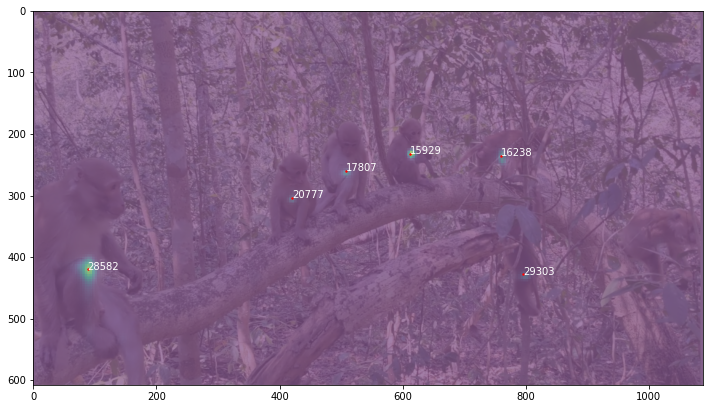

6

In [7]:
img, hm, dets, inds, id_feature = get_info(388, 0.2, model)


#Instanciate tracks with first frame
kalman_filter = KalmanFilter()
tracks = []

detections = [STrack(STrack.tlbr_to_tlwh(tlbrs[:4]), tlbrs[4], f, 30) for
                          (tlbrs, f) in zip(dets[:, :5], id_feature)]

for track in detections:
    track.activate(kalman_filter, 0)
    tracks.append(track)
    
#This has no effect here (as starting velocities are 0)
STrack.multi_predict(tracks)

plot_frame(img = img, hm = hm, top_preds = True, thres = 0.2, text = True)
len(tracks)

[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 6]]
0
1
2
3
4
5


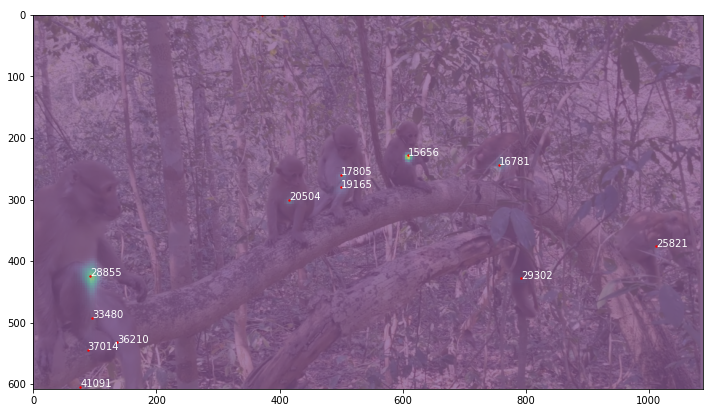

[OT_1_(0-1), OT_2_(0-1), OT_3_(0-1), OT_4_(0-1), OT_5_(0-1), OT_6_(0-1)]


In [8]:
img1, hm1, dets1, inds1, id_feature1 = get_info(389, 0.02, model)
detections1 = [STrack(STrack.tlbr_to_tlwh(tlbrs[:4]), tlbrs[4], f, 30) for
                              (tlbrs, f) in zip(dets1[:, :5], id_feature1)]


_, _, _, tracks, _ = kalman_and_matching(tracks, detections1)
STrack.multi_predict(tracks)
plot_frame(img1, hm1, top_preds = True, thres = 0.02)
print(tracks)

[[0 0]
 [1 2]
 [2 1]
 [3 3]
 [4 4]]
0
1
2
3
4


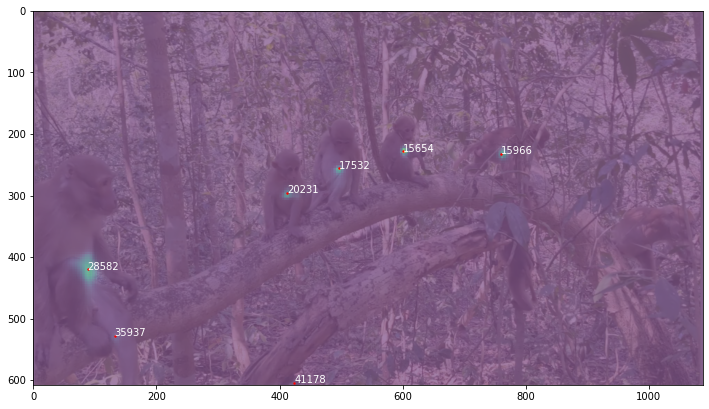

In [9]:
img1, hm1, dets1, inds1, id_feature1 = get_info(390, 0.02, model)
detections1 = [STrack(STrack.tlbr_to_tlwh(tlbrs[:4]), tlbrs[4], f, 30) for
                              (tlbrs, f) in zip(dets1[:, :5], id_feature1)]

emb_dists, iou_dists, dists, tracks, matches = kalman_and_matching(tracks, detections1)
STrack.multi_predict(tracks)
plot_frame(img1, hm1, top_preds = True, thres = 0.02)

In [10]:
STrack.multi_predict(tracks)

### Distance matrices

First, we will get prior detections from the frame before.

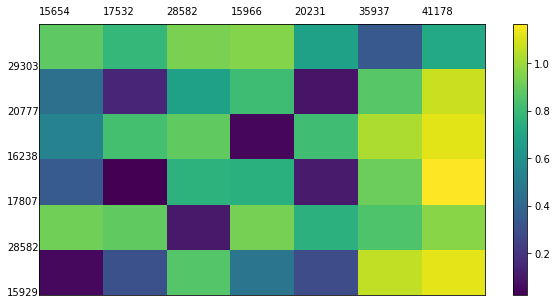

In [12]:
plot_hm(emb_dists, inds, inds1)

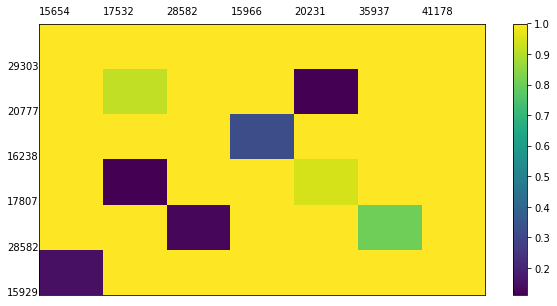

In [13]:
plot_hm(iou_dists, inds, inds1)

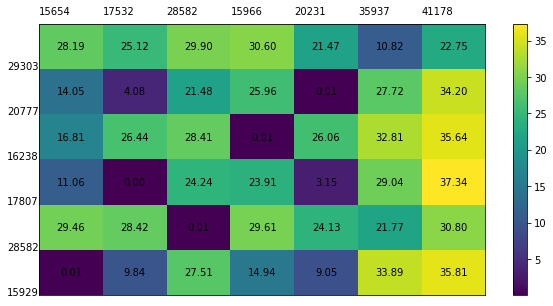

In [14]:
plot_hm(dists, inds, inds1, cell_text = True)

[        594      222.36]
[[     556.52           0]
 [          0       543.2]]
[     86.774      412.02]
[[     5287.5           0]
 [          0        5161]]
[      489.4      249.96]
[[     1097.8           0]
 [          0      1071.5]]
[     758.33      226.95]
[[     525.42           0]
 [          0      512.85]]
[     407.15      288.65]
[[      936.1           0]
 [          0      913.71]]


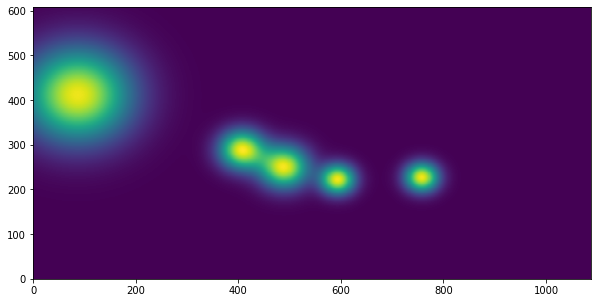

In [15]:
# Using the outputs from the kalman filter

empty_hm = torch.zeros((img1.shape[0], img1.shape[1]))
for itracked, idet in matches:
    track = tracks[itracked]
    
    mu = [608, 1088] * track.mean[:2] / [1080, 1980]
    Sigma = [608, 1088] * track.covariance[:2, :2] / [1080, 1980]
    print(mu)
    print(Sigma)
    X = np.linspace(0, img1.shape[1], img1.shape[1])
    Y = np.linspace(0, img1.shape[0], img1.shape[0])
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z = multivariate_gaussian(pos, mu, Sigma)
    Z = 10 * Z / (np.max(Z) + 0.0000001)
    
    empty_hm = empty_hm + torch.from_numpy(Z)

empty_hm = empty_hm / torch.max(empty_hm)

fig, ax = plt.subplots(figsize = (10, 5))
surf = plt.pcolormesh(empty_hm)

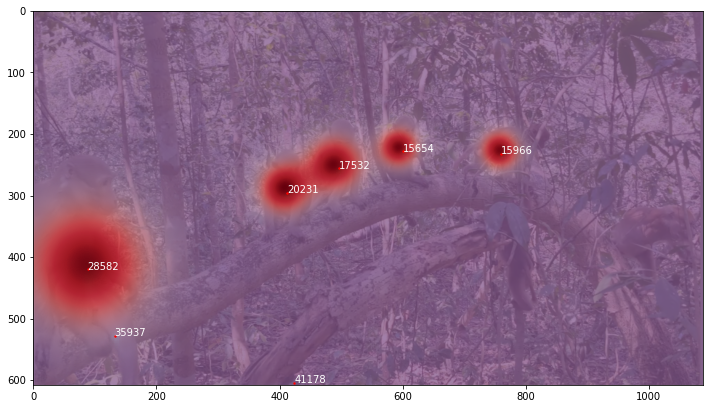

In [16]:
img1, hm1, dets1, inds1, id_feature1 = get_info(390, 0.02, model)
plot_frame(img = img1, hm = hm1, pred_hm = empty_hm, top_preds = True, thres = 0.02)

### Visualize Embeddings

In [1629]:
det = 16672 # for which object
track = 16400 # compare with which prior track

i = int(np.where(inds1 == det)[0])
j = int(np.where(inds == track)[0])

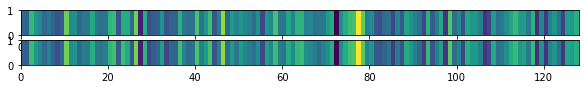

In [1630]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 1))

ax2.pcolormesh(id_feature1[i:(i+1),:])
ax1.pcolormesh(id_feature[j:(j+1),:])

In [764]:
tracks[1].covariance

array([[     275.87,           0,           0,           0,      65.684,           0,           0,           0],
       [          0,      275.87,           0,           0,           0,      65.684,           0,           0],
       [          0,           0,  0.00019608,           0,           0,           0,  9.8039e-11,           0],
       [          0,           0,           0,      275.87,           0,           0,           0,      65.684],
       [     65.684,           0,           0,           0,      399.07,           0,           0,           0],
       [          0,      65.684,           0,           0,           0,      399.07,           0,           0],
       [          0,           0,  9.8039e-11,           0,           0,           0,       2e-10,           0],
       [          0,           0,           0,      65.684,           0,           0,           0,      399.07]])

## Visualize heatmaps

In [831]:
cap = cv2.VideoCapture("/usr/users/agecker/datasets/macaque_videos/Videos/VID_20210223_123817_0.mp4")

loaded ../models/mcqcp/mcqcp10.pth, epoch 10
loaded ../models/mcqcp/mcqcp20.pth, epoch 20
loaded ../models/mcqcp/mcqcp30.pth, epoch 30
loaded ../models/mcqcp/mcqcp40.pth, epoch 40
loaded ../models/mcqcp/mcqcp50.pth, epoch 10
loaded ../models/mcqcp/mcqcp60.pth, epoch 20
loaded ../models/mcqcp/mcqcp70.pth, epoch 10
loaded ../models/mcqcp/mcqcp80.pth, epoch 20
loaded ../models/mcqcp/mcqcp90.pth, epoch 30
loaded ../models/mcqcp/mcqcp100.pth, epoch 40
loaded ../models/mcqcp/mcqcp110.pth, epoch 10
loaded ../models/mcqcp/mcqcp120.pth, epoch 20
loaded ../models/mcqcp/mcqcp130.pth, epoch 30
loaded ../models/mcqcp/mcqcp140.pth, epoch 40
loaded ../models/mcqcp/mcqcp150.pth, epoch 10
loaded ../models/mcqcp/mcqcp160.pth, epoch 20
loaded ../models/mcqcp/mcqcp170.pth, epoch 30
loaded ../models/mcqcp/mcqcp180.pth, epoch 40
loaded ../models/mcqcp/mcqcp190.pth, epoch 10
loaded ../models/mcqcp/mcqcp200.pth, epoch 20


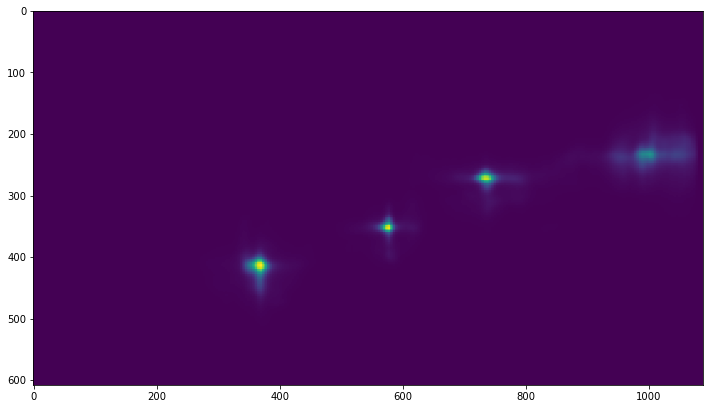

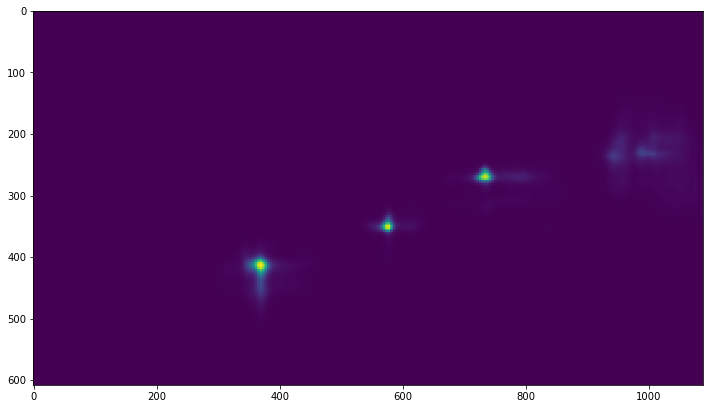

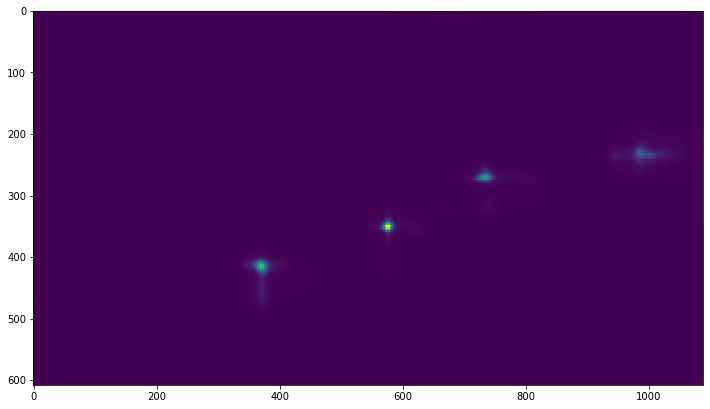

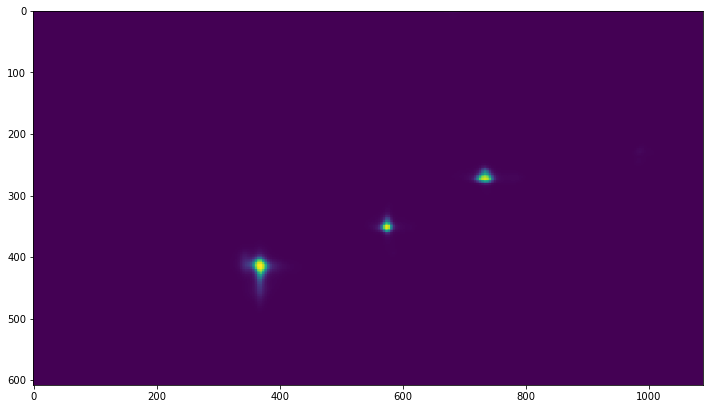

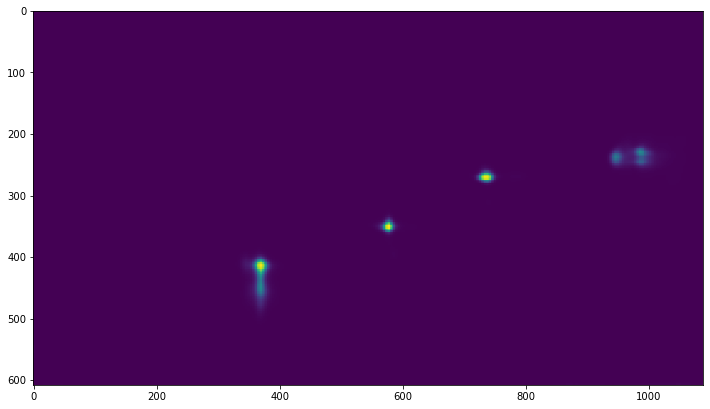

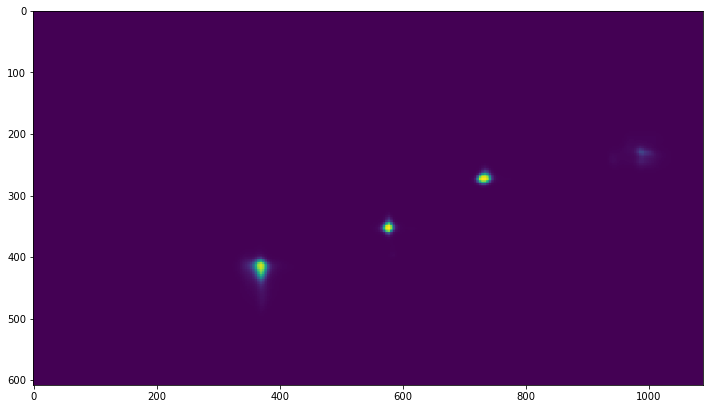

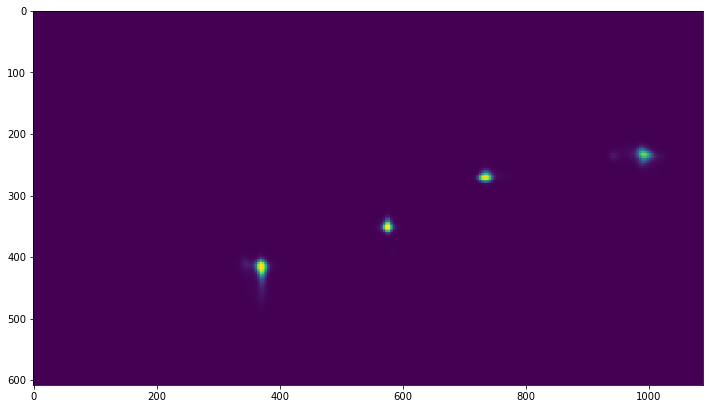

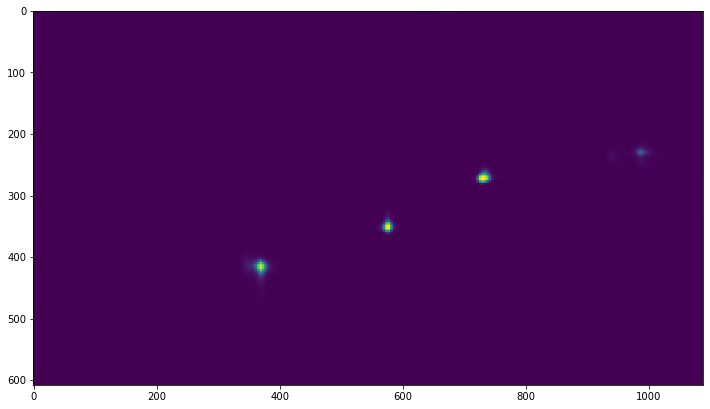

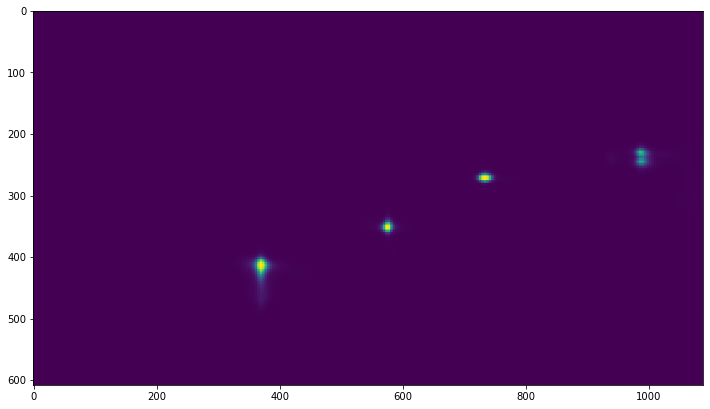

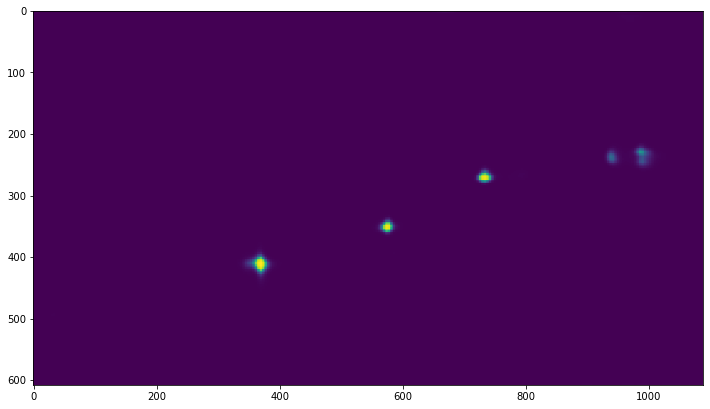

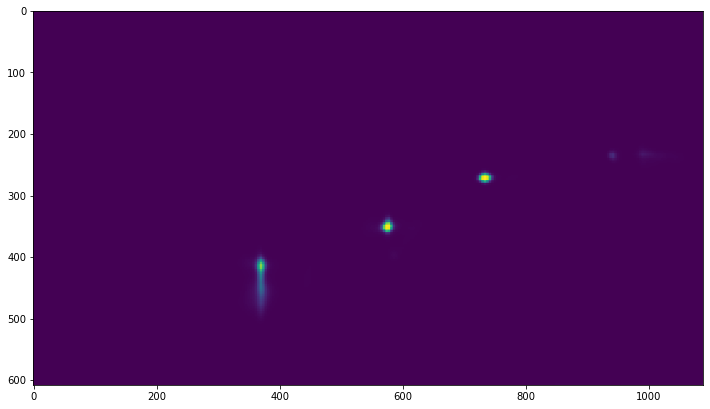

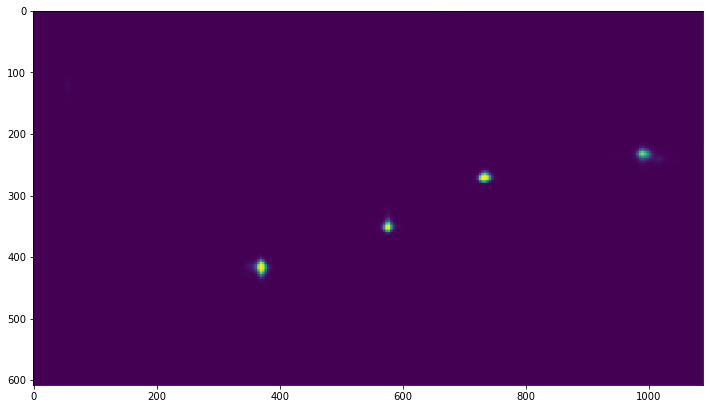

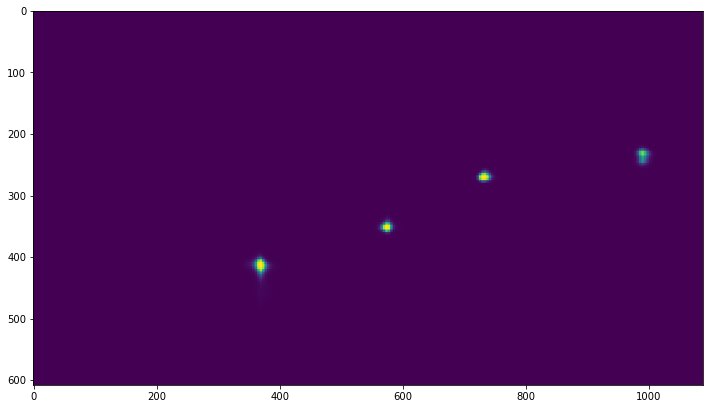

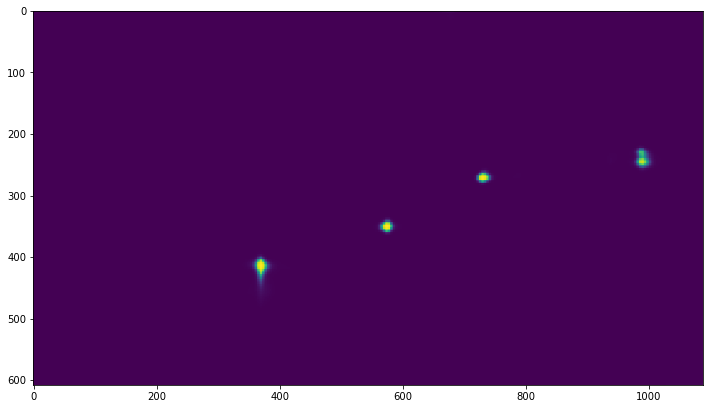

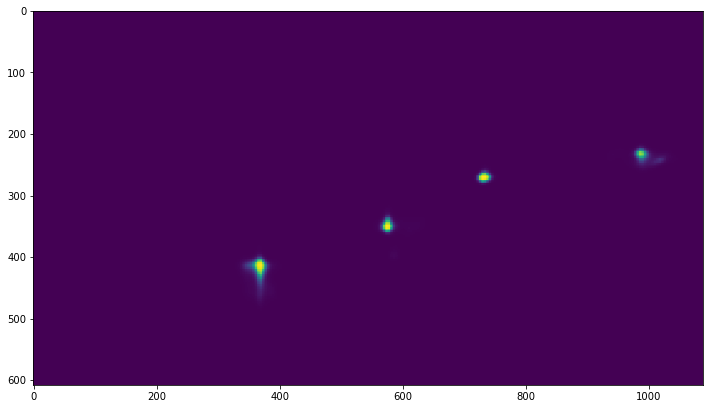

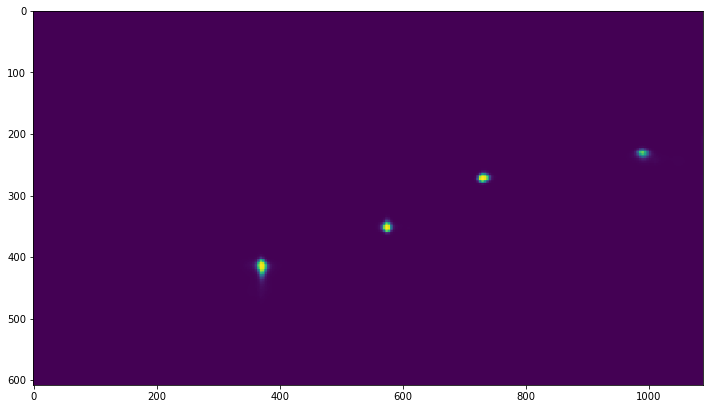

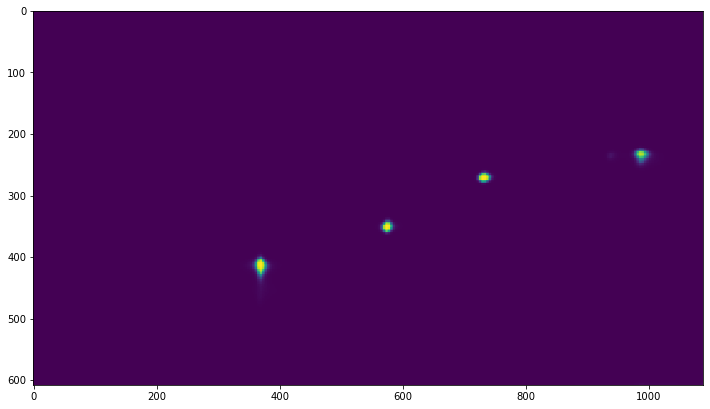

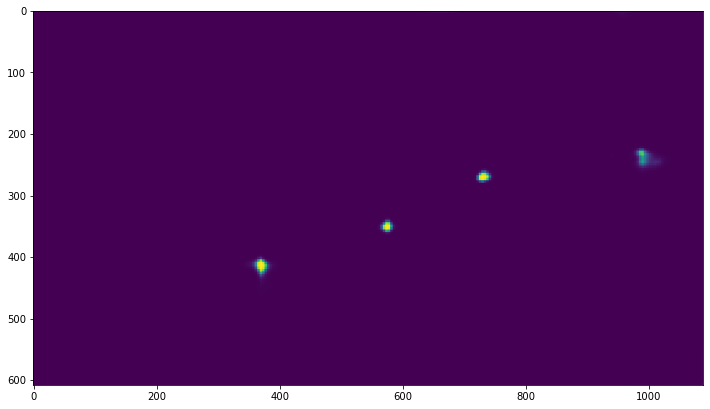

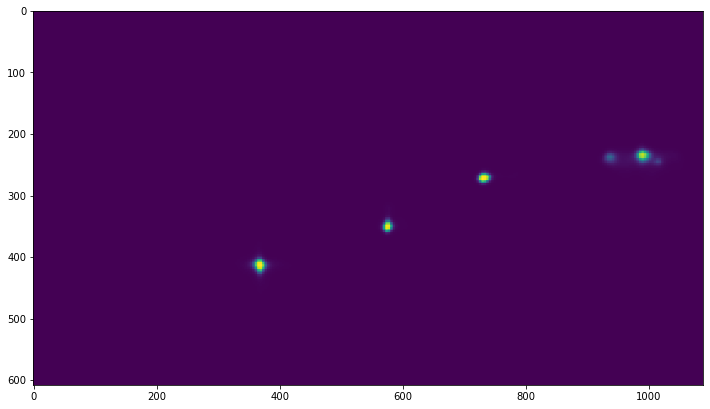

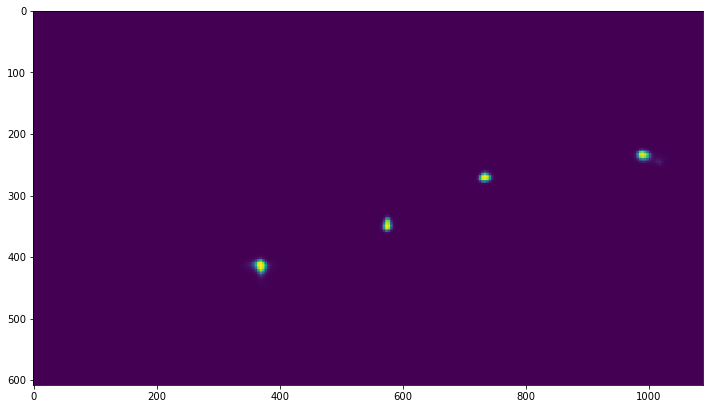

In [898]:
model = create_model('dla_34', heads =  {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, 
                     head_conv = 256)

plot_list = []


for i in range(10,210, 10):
    model = load_model(model, '../models/mcqcp/mcqcp'+str(i)+'.pth')
    model = model.to(torch.device('cuda'))
    model.eval()

    img1, hm1, dets1, inds1, id_feature1 = get_info(155, 0.004, model)
    plot_list.append(plot_frame(None, hm1, top_preds = False, thres = 0.04))

loaded ../models/mcqcp/mcqcp50.pth, epoch 10


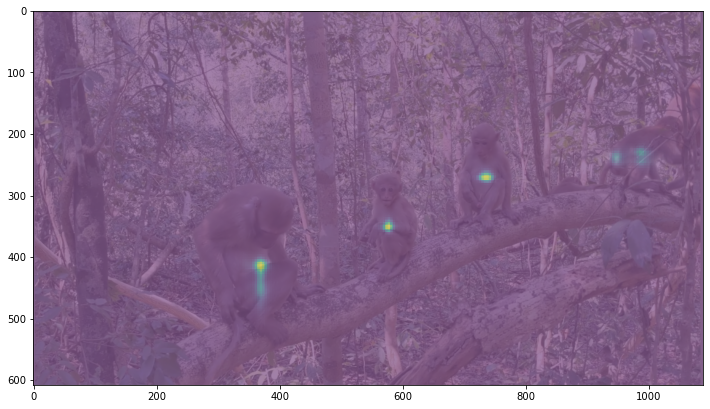

In [961]:
model50 = load_model(model, '../models/mcqcp/mcqcp50.pth')
model50 = model50.to(torch.device('cuda'))
model50.eval()

img1, hm1, dets1, inds1, id_feature1 = get_info(155, 0.004, model50)
plot_frame(img1, hm1, top_preds = False, thres = 0.004)

In [890]:

model200 = load_model(model, '../models/mcqcp/mcqcp200.pth')
model200 = model200.to(torch.device('cuda'))
model200.eval()


img1, hm1, dets1, inds1, id_feature1 = get_info(155, 0.004, model200)
plot_frame(img1, hm1, top_preds = False, thres = 0.004)

loaded ../models/mcqcp/mcqcp200.pth, epoch 20


AttributeError: module 'models.model' has no attribute 'state_dict'

loaded ../models/mcqcp/mcqcp210.pth, epoch 30


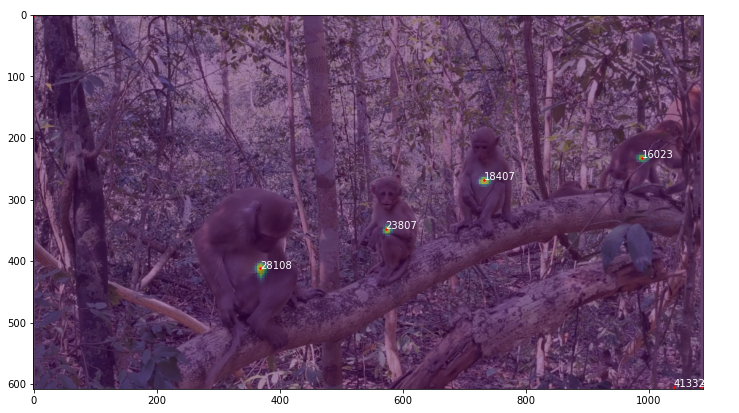

In [837]:
model210 = load_model(model, '../models/mcqcp/mcqcp210.pth')
model210 = model210.to(torch.device('cuda'))
model210.eval()


img1, hm1, dets1, inds1, id_feature1 = get_info(155, 0.004, model210)
plot_frame(img1, hm1, top_preds = True, thres = 0.004)

## Interactive exploration

In [1459]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [1460]:
model = create_model('dla_34', heads =  {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}, 
                     head_conv = 256)

In [1462]:
frame_slider = widgets.IntSlider(description = "Frame", min = 0, max = 390)
model_slider = widgets.IntSlider(description = "Model", min = 10, max = 220, step = 10)
plot_button = widgets.Button(description = "Plot")
image_chbx = widgets.Checkbox(value=True, description='Show image')
output = widgets.Output()
display(frame_slider, model_slider, image_chbx, output)

model_curr = load_model(model, '../models/mcqcp/model_' + str(model_slider.value) + '.pth')
model_curr = model_curr.to(torch.device('cuda'))
model_curr.eval()

with output:
    img1, hm1, dets1, inds1, id_feature1 = get_info(frame_slider.value, 0.1, model_curr)
    plot_frame(img1, hm1, top_preds = True, thres = 0.1)

def frame_event_handler(btn):
    with output:
        clear_output()
        img1, hm1, dets1, inds1, id_feature1 = get_info(frame_slider.value, 0.1, model_curr)
        plot_frame(img1 if image_chbx.value else None, hm1, top_preds = image_chbx.value, thres = 0.01)
        
def model_event_handler(btn):
    with output:
        clear_output()
        model_curr = load_model(model, '../models/mcqcp/model_' + str(model_slider.value) + '.pth')
        model_curr = model_curr.to(torch.device('cuda'))
        model_curr.eval()
        img1, hm1, dets1, inds1, id_feature1 = get_info(frame_slider.value, 0.1, model_curr)
        plot_frame(img1 if image_chbx.value else None, hm1, top_preds = image_chbx.value, thres = 0.01)
        
def image_event_handler(btn):
    with output:
        clear_output()
        img1, hm1, dets1, inds1, id_feature1 = get_info(frame_slider.value, 0.1, model_curr)
        plot_frame(img1 if image_chbx.value else None, hm1, top_preds = image_chbx.value, thres = 0.01)
    

frame_slider.observe(frame_event_handler)
model_slider.observe(model_event_handler)
image_chbx.observe(image_event_handler)

IntSlider(value=0, description='Frame', max=390)

IntSlider(value=10, description='Model', max=220, min=10, step=10)

Checkbox(value=True, description='Show image')

Output()

loaded ../models/mcqcp/model_10.pth, epoch 10
